In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot
import os
from copy import deepcopy

from time import time

from math import ceil
from scipy.stats import spearmanr, gamma, poisson

from anndata import AnnData, read_h5ad
import scanpy as sc
from scanpy import read
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torch import tensor
from torch.cuda import is_available

from sciPENN.Preprocessing import preprocess
from sciPENN.sciPENN_API import sciPENN_API

from matplotlib import colors as mcolors



In [3]:
"""Read in Raw Data"""
adata_gene_train = sc.read("/home/asmauger/biostat625final/rna_train_hvg.h5ad")
adata_protein_train = sc.read("/home/asmauger/biostat625final/prot_train.h5ad")
adata_gene_test = sc.read("/home/asmauger/biostat625final/rna_test_hvg.h5ad")
adata_protein_test = sc.read("/home/asmauger/biostat625final/prot_test.h5ad")

In [4]:
adata_protein_test.obs.head()
#adata_gene_test.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,cell_id,day,donor,cell_type,technology,daydonor,ident
45006fe3e4c8,SeuratProject,613.0,103,45006fe3e4c8,2,32606,HSC,citeseq,day232606,SeuratProject
d02759a80ba2,SeuratProject,1191.0,114,d02759a80ba2,2,32606,HSC,citeseq,day232606,SeuratProject
b646f9b319d5,SeuratProject,1120.0,110,b646f9b319d5,2,32606,NeuP,citeseq,day232606,SeuratProject
14872957f6f5,SeuratProject,749.0,104,14872957f6f5,2,32606,HSC,citeseq,day232606,SeuratProject
9b761504056d,SeuratProject,1022.0,107,9b761504056d,2,32606,HSC,citeseq,day232606,SeuratProject


In [5]:
sciPENN = sciPENN_API(gene_trainsets = [adata_gene_train], protein_trainsets = [adata_protein_train], 
                      gene_test = adata_gene_test, train_batchkeys = ['daydonor'], test_batchkey = 'daydonor',  use_gpu=False,
                     select_hvg=False, cell_normalize=False, log_normalize=False, min_cells=0, min_genes=0)

Using CPU

Normalizing Gene Training Data by Batch


100%|██████████| 9/9 [00:01<00:00,  6.65it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 9/9 [00:00<00:00, 18.16it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 9/9 [00:01<00:00,  6.44it/s]


In [6]:
sciPENN.train(quantiles = [0.1, 0.25, 0.75, 0.9], n_epochs = 10000, ES_max = 12, decay_max = 6, 
             decay_step = 0.1, lr = 10**(-3), weights_dir = "pbmc_to_pbmc", load = True)

In [7]:
sciPENN.predict()

AnnData object with n_obs × n_vars = 35492 × 134
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'day', 'donor', 'cell_type', 'technology', 'daydonor', 'ident', 'batch'
    layers: 'q10', 'q25', 'q75', 'q90'

In [29]:
scipenn_embedding = sciPENN.embed()

In [85]:

#scipenn_embedding.T.write("/home/asmauger/biostat625final/embedding.h5ad")


In [10]:
imputed_test = sciPENN.predict()



adata_protein_test.layers['imputed'] = imputed_test.X
adata_protein_test.layers.update(imputed_test.layers)

# scaling by batch
batches = np.unique(adata_protein_test.obs['daydonor'].values)

for i in batches:
    indices = [x == i for x in adata_protein_test.obs['daydonor']]
    sub_adata = adata_protein_test[indices]

    sc.pp.scale(sub_adata)
    adata_protein_test[indices] = sub_adata.X

/home/adityabn/.conda/envs/scipenn_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
#adata_protein_test.T.write("/home/asmauger/biostat625final/protein_test_final.h5ad")

In [14]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            corrs[i] = spearmanr(A[i], B[i])[0]
            
        return corrs

In [15]:
corrs = corr2_coeff(adata_protein_test.layers["imputed"].T, adata_protein_test.X.T)
corrs = pd.DataFrame(corrs)
corrs.index = adata_protein_test.var.index
corrs = corrs.dropna()

In [67]:
MSEs = ((adata_protein_test.X - adata_protein_test.layers["imputed"])**2).mean(axis = 0)**(1/2)
avg_exp = sc.read("/home/asmauger/biostat625final/prot_test.h5ad").X.mean(axis = 0)
avg_exp = np.squeeze(np.asarray(avg_exp))
metrics = pd.DataFrame({"Correlation":corrs[0],"RMSE":MSEs,"AVG": avg_exp})

In [ ]:
#metrics.to_csv("/home/asmauger/biostat625final/metrics.csv")

In [79]:
import matplotlib.pyplot as plt

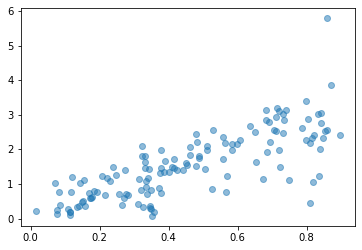

In [84]:
plt.scatter(corrs, avg_exp,alpha=0.5)